In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
df_train = pd.read_csv("../data/internal/ml/train_7d.csv")
df_test = pd.read_csv("../data/internal/ml/test_7d.csv")
df_sp500 = pd.read_csv("../data/external/s&p500_returns_adrianmross.csv")

In [4]:
df_sp500["date"] = pd.to_datetime(df_sp500["date"])

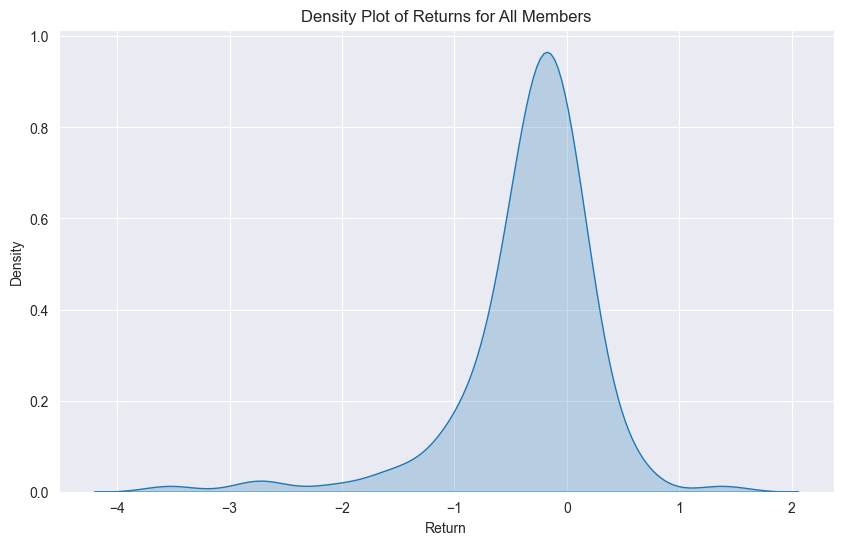

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_train, x='normalized_return', fill=True)
plt.title('Density Plot of Returns for All Members')
plt.xlabel('Return')
plt.ylabel('Density')
plt.show()

In [21]:
def calc_threshold(df):
    returns = df_train["normalized_return"].to_list()
    median_return = np.median(returns)
    std_return = np.std(returns)
    threshold = median_return + (std_return * 0.25)
    return threshold

threshold_train = calc_threshold(df_train)
threshold_test = calc_threshold(df_test)

2 categories:
1. anomalous: return > mean_return + std_return
2. normal: return <= mean_return + std_return

In [23]:
df_train["category"] = df_train["normalized_return"].apply(lambda x: 1 if x > threshold_train else 0)
print(len(df_train[df_train["category"] == 1]), len(df_train[df_train["category"] == 0]))

df_test["category"] = df_test["normalized_return"].apply(lambda x: 1 if x > threshold_test else 0)
print(len(df_test[df_test["category"] == 1]), len(df_test[df_test["category"] == 0]))

45 94
25 34


In [24]:
X_train = df_train.drop(
    ["name", "avg_return", "return_volatility", "cumulative_return", "start_date", "end_date",
     "sp500_cumulative_return", "normalized_return", "category"], axis=1)
y_train = df_train["category"]

X_test = df_test.drop(["name", "avg_return", "return_volatility", "cumulative_return", "start_date", "end_date",
     "sp500_cumulative_return", "normalized_return", "category"], axis=1)
y_test = df_test["category"]


## Random Forest Classifier

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__max_features=auto, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max

/Users/liamtessendorf/Programming/Uni/2_Master/3_FS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
446 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/liamtessendorf/Programming/Uni/2_Master/3_FS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/liamtessendorf/Programming/Uni/2_Master/3_FS24_Programming/us-congress-members-trading-analysis/venv/li

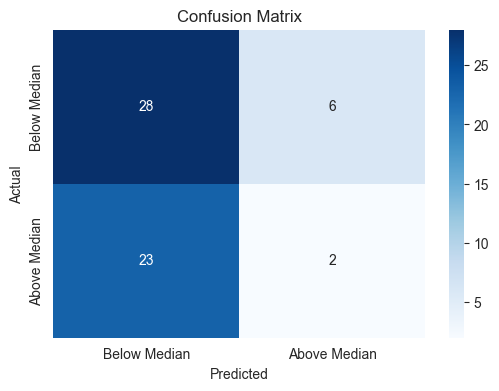

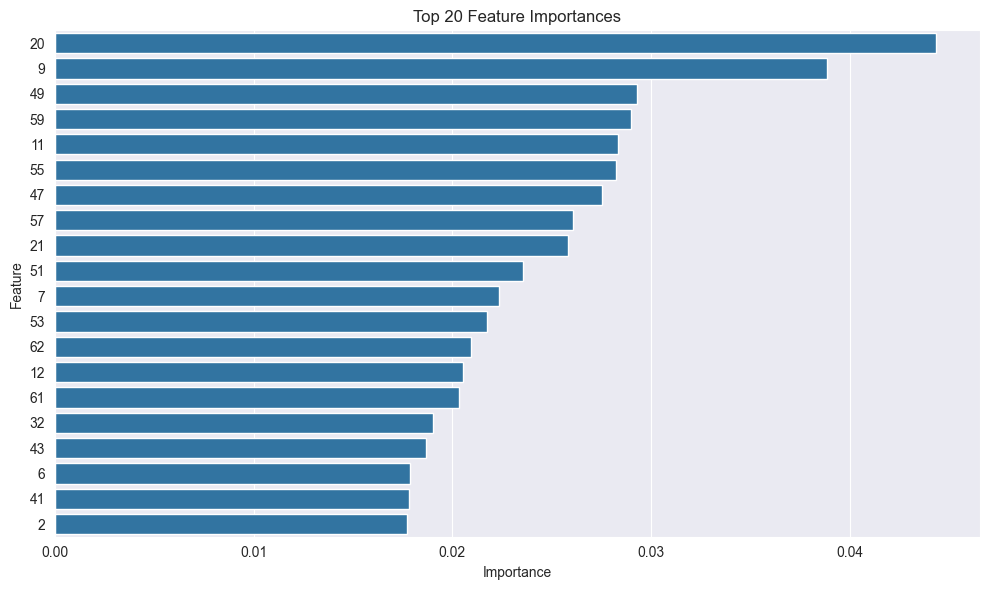

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Assuming previous steps for data loading, preprocessing, and feature engineering have been completed

# Step 1: Prepare the Feature Matrix and Target Variable
# X_train, X_test, y_train, y_test are already defined from previous steps

# Step 2: Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Step 3: Create a Pipeline
pipeline = Pipeline([
    # ('scaler', StandardScaler()),  # Uncomment if scaling is desired
    ('classifier', rf_classifier)
])

# Step 4: Define Hyperparameter Grid
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Step 5: Set Up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Step 6: Fit the Model
grid_search.fit(X_train, y_train)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
print("Best Hyperparameters:\n", grid_search.best_params_)

# Step 7: Evaluate the Model on Test Data
y_pred = best_model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Below Median', 'Above Median'],
            yticklabels=['Below Median', 'Above Median'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Accuracy on Test Set: 0.3898

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.26      0.33        34
           1       0.36      0.56      0.44        25

    accuracy                           0.39        59
   macro avg       0.40      0.41      0.39        59
weighted avg       0.41      0.39      0.38        59



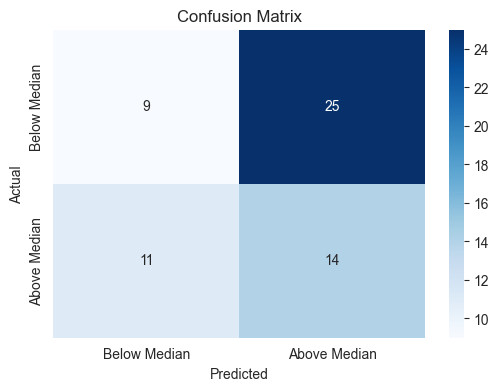

Top 10 Features by Absolute Coefficient Value:
   feature  coefficient  abs_coefficient
4        4    -1.037760         1.037760
26      26    -1.014382         1.014382
20      20     1.006495         1.006495
58      58    -1.005787         1.005787
61      61     0.937156         0.937156
32      32    -0.901159         0.901159
12      12     0.886039         0.886039
47      47    -0.854306         0.854306
49      49    -0.628238         0.628238
51      51     0.621516         0.621516


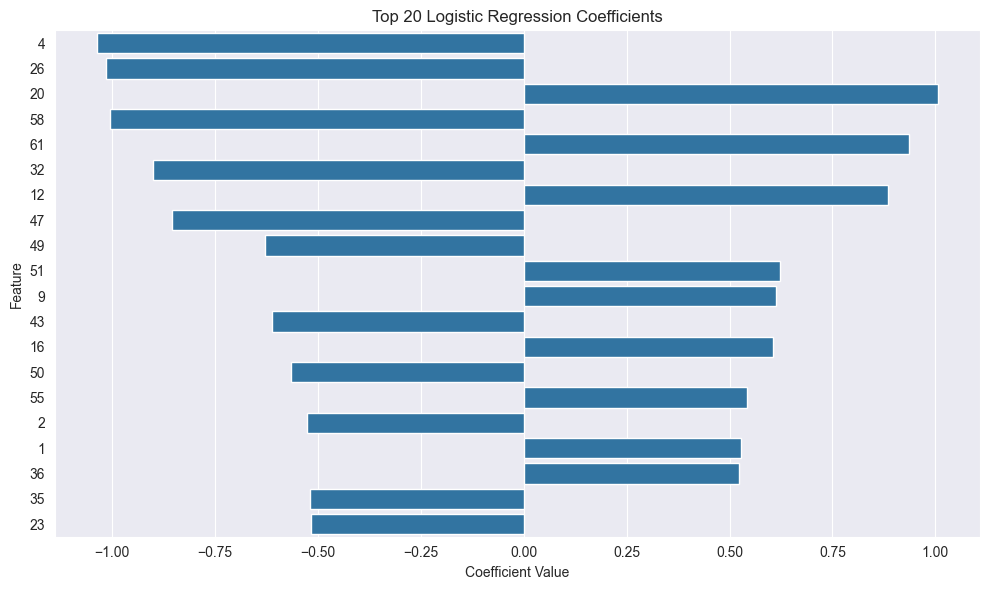

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and Train the Logistic Regression Model
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)
logistic_regressor.fit(X_train_scaled, y_train)

# Make Predictions on the Test Set
y_pred = logistic_regressor.predict(X_test_scaled)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Below Median', 'Above Median'],
            yticklabels=['Below Median', 'Above Median'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Analyze Model Coefficients
feature_names = X_train.columns
coefficients = logistic_regressor.coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Display top 10 features
print("Top 10 Features by Absolute Coefficient Value:")
print(coef_df_sorted.head(10))

# Plot the top 20 coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='coefficient', y='feature', data=coef_df_sorted.head(20))
plt.title('Top 20 Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()